# NLP Classify tweets if they are real danger or not:

## Libraries:

In [8]:
import pandas as pd 
import numpy as np 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Flatten, GlobalMaxPool1D, Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/spavot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/spavot/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data importation:

In [10]:
train = pd.read_csv('/Users/spavot/Documents/Perso/NLP Real or not/Data/train.csv')
test = pd.read_csv('/Users/spavot/Documents/Perso/NLP Real or not/Data/test.csv')

## Data exploration:

Let's see and distinguish our dependents and independent variables:

In [12]:
train.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [14]:
test.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


We have 10 000 rows divided in 70% train and 30% test, 4 variables but only three are dependents variable as the first one is only the i. Our target variable is target obviously. Let's inspect our target first:

#### Target analysis:

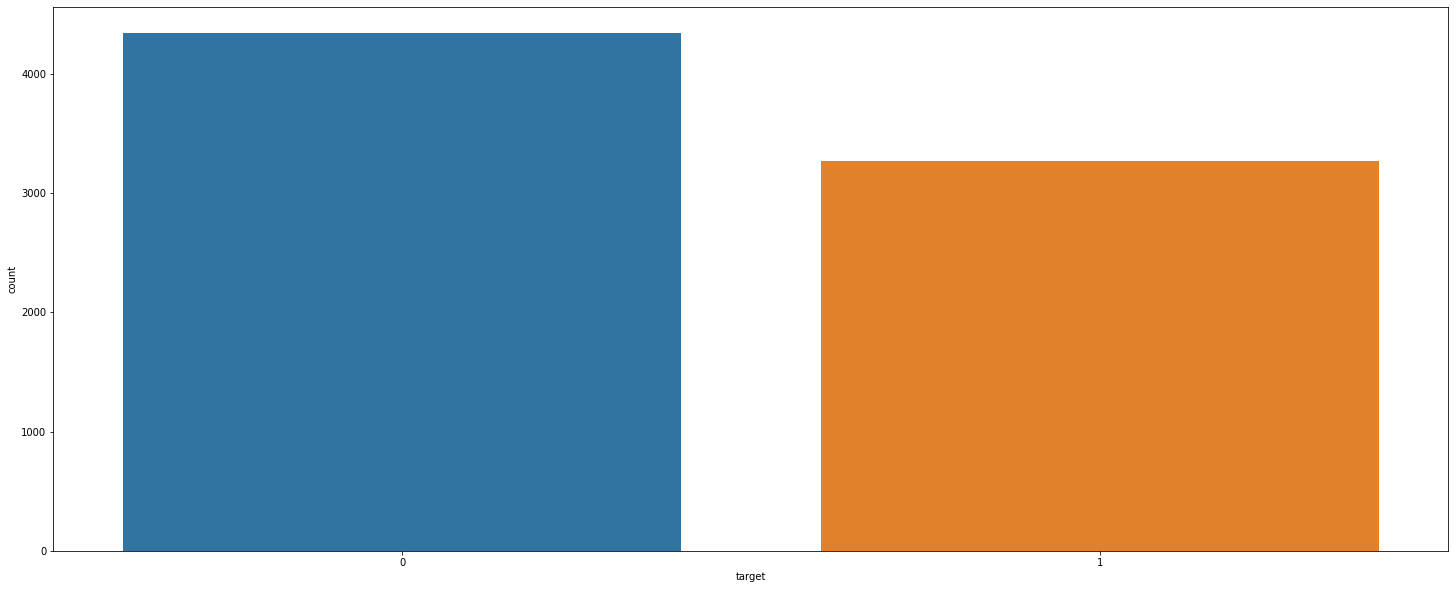

In [16]:
plt.figure(figsize=(25,10))
sns.countplot(train.target)
plt.show()

Seems like we have a litle more tweets that are not real disaster as target take the value 1 in this case.

#### Location analysis:

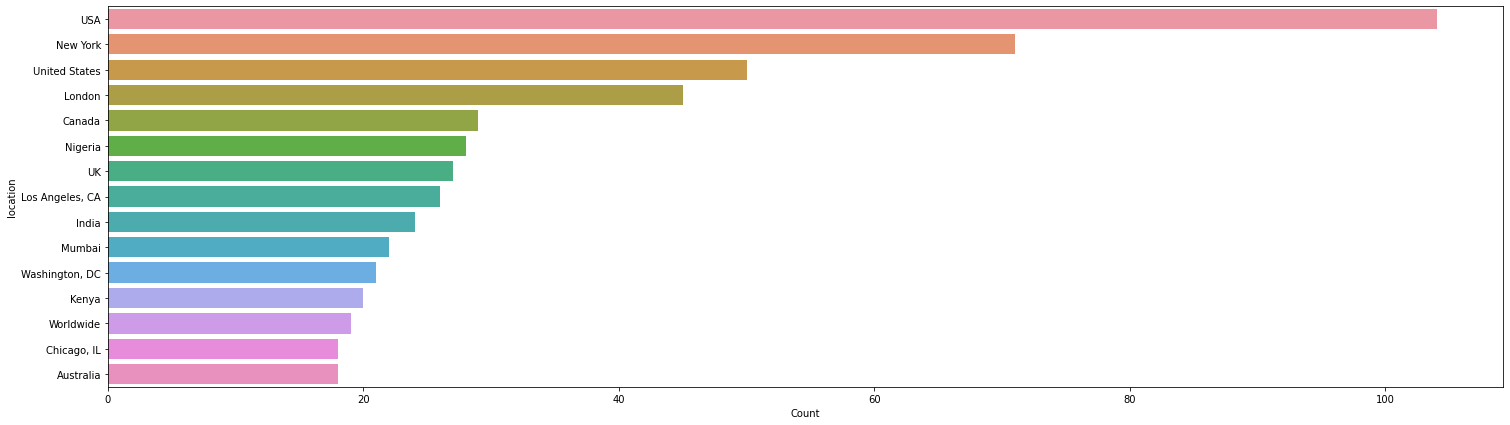

In [18]:
location = train.location
location = pd.DataFrame(location)
location['Count'] = 1
location = location.groupby('location').sum().sort_values(by = 'Count', ascending = False).nlargest(15,['Count'])
location = location.reset_index()
plt.figure(figsize=(25,7))
sns.barplot(x = 'Count', y = 'location', data = location)
plt.show()

In [20]:
print("There is", train.location.nunique(), "differents location.")

There is 3341 differents location.


#### Keywords analysis

In [22]:
train.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
harm                     41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [24]:
print("There is", train.keyword.nunique(), "differents keywords.")

There is 221 differents keywords.


In [26]:
print("Number of missings values:", train.keyword.isna().sum())

Number of missings values: 61


There is missing values that we will need to replace.

#### Text analysis

In [28]:
train.text.head(10)

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to &#39;shelter in place&#39; are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update =&gt; California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I&#39;m on top of the hill and I can see a fire in...
8    There&#39;s an emergency evacuation happening now ...
9    I&#39;m afraid that the tornado is coming to our a...
Name: text, dtype: object

We have some special characters, uppercases and other noise that we will need to remove before modeling.

&lt;AxesSubplot:ylabel=&#39;Density&#39;&gt;

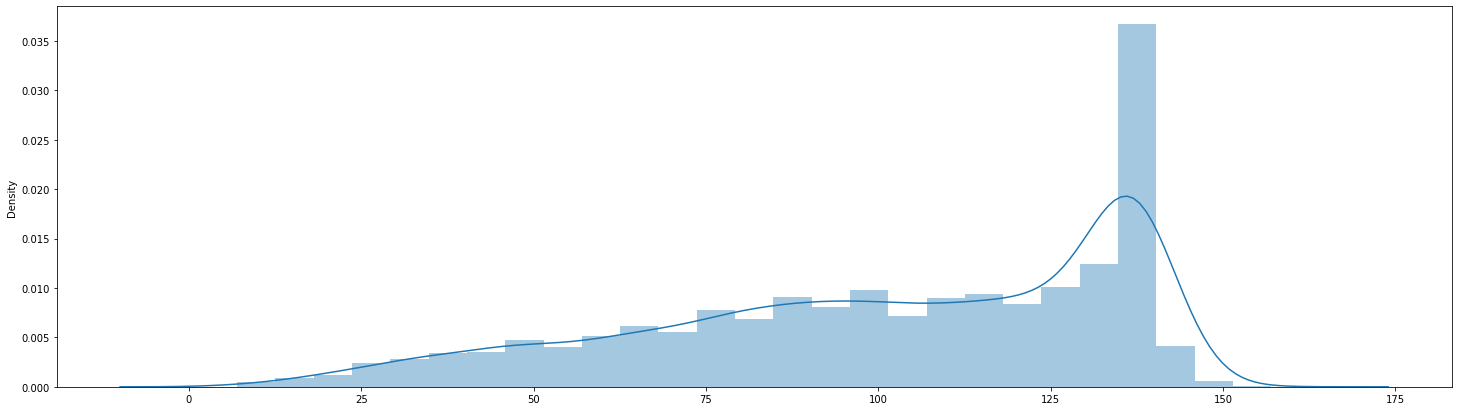

In [30]:
length_tweets = pd.DataFrame(train.text)
length_measured = []
for i in length_tweets.text:
 length_measured.append(len(i))

plt.figure(figsize=(25,7))
sns.distplot(length_measured)

We can see that we have tweets of different lengths but overall it flucluates between 75 and 140.

As we saw that there is different lengths of tweets, let's check if there is a possible impact on our target.

&lt;AxesSubplot:xlabel=&#39;target&#39;, ylabel=&#39;Len&#39;&gt;

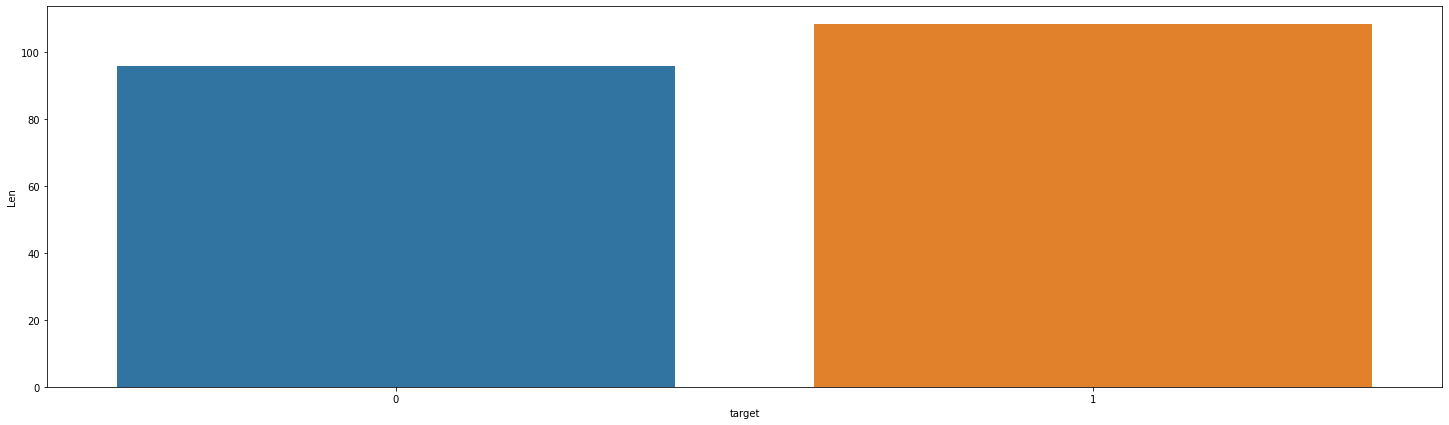

In [32]:
length_tweets = train[['text','target']]
length_measured = []
for i in length_tweets.text:
 length_measured.append(len(i))

length_tweets['Len'] = length_measured
avg = length_tweets.groupby('target').mean()
avg = avg.reset_index()
plt.figure(figsize=(25,7))
sns.barplot(x = "target", y = "Len", data = avg)

We can see that there is a difference between tweets in terms of lengths between real and not real disasters tweets. We will need to use this information for our models.

We had an overview of the data, now let's start working on data cleaning.

### Data cleaning:

Let's first replace the missing values:

In [34]:
for i, y in zip(train.columns, test.columns):
    print("Train", i, train[i].isna().sum())
    print("Test", i, test[i].isna().sum())


Train id 0
Test id 0
Train keyword 0
Test keyword 0
Train location 0
Test location 0
Train text 0
Test text 0


We replace missing values in location with "unknown":

In [36]:
train.location = train.location.fillna('Unknown')
test.location = test.location.fillna('Unknown')

We now replace missing keyword with "missing":

In [38]:
train.keyword = train.keyword.fillna('Missing')
test.keyword = test.keyword.fillna('Missing')

#### Keyword cleaning:

We need to remove the special characters and numbers:

In [40]:
#Replace punctuations and special characters
train.keyword = train.keyword.str.replace(r'[^\w\s]', '', case=False)
test.keyword = test.keyword.str.replace(r'[^\w\s]', '', case=False)

In [42]:
#Replace non alphabetics text
train.keyword = train.keyword.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test.keyword = test.keyword.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [44]:
train.keyword.value_counts()

              1165
Missing         61
fatalities      45
deluge          42
armageddon      42
              ... 
battle          26
rescue          22
epicentre       12
threat          11
inundation      10
Name: keyword, Length: 187, dtype: int64

It seems good, let's now clean the text variable.

#### Text cleaning:

Before cleaning, we intiate a column to get the length of tweets before beeing cleaned:

In [46]:
#Train set 
length_measured = []
for i in train.text:
 length_measured.append(len(i))
train['Length'] = length_measured
#Test set
length_measured = []
for i in test.text:
 length_measured.append(len(i))
test['Length'] = length_measured

In [48]:
#Transform to lower
train.text = train.text.str.lower()
test.text = test.text.str.lower()

In [50]:
#Remove urls:
train.text = train.text.str.replace('http\S+|www.\S+', '', case=False)
test.text = test.text.str.replace('http\S+|www.\S+', '', case=False)

## EXTRACT HASHTAGS

In [52]:
#Remove hashtag character
train.text = train.text.str.replace('#', '', case=False)
test.text = test.text.str.replace('#', '', case=False)

In [53]:
#Remove punctuation, special characters & mentions:
train.text = train.text.str.replace(r'[^\w\s]', '', case=False)
test.text = test.text.str.replace(r'[^\w\s]', '', case=False)

In [54]:
# #Remove stopwords:
stop_words = set(stopwords.words('english'))
train.text = train.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test.text = test.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [55]:
#Remove non alphabetic words:
train.text = train.text.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test.text = test.text.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [56]:
#Initiate a lemmatizer and lemmatize each word in the data
lemmatizer = WordNetLemmatizer()
train.text = train.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
test.text = test.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [57]:
for i,y in enumerate(train.text):
    if i <=15:
        print(train.text[i])

deed reason earthquake may allah forgive u
forest fire near la ronge sask canada
resident asked shelter place notified officer evacuation shelter place order expected
people receive wildfire evacuation order california
got sent photo ruby alaska smoke wildfire pours school
rockyfire update california hwy closed direction due lake county fire cafire wildfire
flood disaster heavy rain cause flash flooding street manitou colorado spring area
im top hill see fire wood
emergency evacuation happening building across street
im afraid tornado coming area
three people died heat wave far
haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding
raining flooding florida tampabay tampa day ive lost count
flood bago myanmar arrived bago
damage school bus multi car crash breaking
whats man


It seems good!